In [1]:
import numpy as np
import math
from timeit import default_timer as timer
import scipy
import random
from random import choices
from scipy import integrate
from scipy import interpolate
from scipy.interpolate import griddata
from scipy.sparse import csr_matrix
from scipy.sparse import dok_matrix
import scipy.stats as st
from scipy.optimize import fsolve
import heapq
import sys
import importlib
import healpy as hp
#import myUnitsCopy1 as myU # customized library for units. All dimensional variables are in GeV and GeV=1
import pandas as pd

from astropy.time import Time
from time import time as tictoc

import MyUnits as myU

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import *

In [2]:
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
import astropy.units as u
import matplotlib.pyplot as plt

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [3]:
from os import listdir
import gzip

# Load in a single edr3 file

In [119]:
N_8 = 2**(59-16)
N_12 = 2**(59-24)

list_dr3_files = listdir('./edr3_data')

healpix_numbers_start = np.empty((len(list_dr3_files)),dtype= int)
healpix_numbers_end = np.empty((len(list_dr3_files)), dtype = int)
for i,file in enumerate(list_dr3_files):
    int_1 = int(file[11:17])
    int_2 = int(file[18:24])
    healpix_numbers_start[i] = int_1
    healpix_numbers_end[i] = int_2
    
dr32_sid_start = [x*N_8 for x in healpix_numbers_start]
dr32_sid_end = [x*N_8 for x in healpix_numbers_end]

In [120]:
print("Pixels at level 8 (start): " + str(healpix_numbers_start))
print("Pixels at level 8 (end): " + str(healpix_numbers_end))

print("Corresponding source IDs in dr2 (start) : " + str(dr32_sid_start))
print("Corresponding source IDs in dr2 (end) : " + str(dr32_sid_end))

Pixels at level 8 (start): [     0  22882 603105]
Pixels at level 8 (end): [  3111  23058 603165]
Corresponding source IDs in dr2 (start) : [0, 201272200534163456, 5304967682158755840]
Corresponding source IDs in dr2 (end) : [27364645392089088, 202820312906072064, 5305495447740088320]


In [4]:
#dr3 = pd.read_csv('./edr3_data/GaiaSource_603105-603165.csv')
dr3 = pd.read_csv('/Users/crimondino/Dropbox (PI)/MyLensVelocity2/data/acc_catalog/edr3/GaiaSource_603105-603165.csv.gz', compression = 'gzip')
dr3.shape

(509444, 99)

## Open the corresponding dr2 files

In [6]:
#dr2_data = './data/dr2/' # Replace this with the path to dr2 data
dr2_data = '/Users/crimondino/Dropbox (PI)/MyLensVelocity2/data/acc_catalog/dr2/' # Replace this with the path to dr2 data

list_dr2_files = listdir(dr2_data); 
list_files = [file for file in list_dr2_files if file[-7:]=='.csv.gz'] #select only files ending with 'csv.gz'

print('total number of EDR2 files =', len(list_files));
print('first 14 files:')
[print(file) for file in list_files[0:13]];

dr2 = pd.concat((pd.read_csv(dr2_data+ str(f), compression = 'gzip') for f in list_files))
dr2.shape

total number of EDR2 files = 14
first 14 files:
GaiaSource_5305361582201067648_5305404639272393856.csv.gz
GaiaSource_5305196277500038912_5305235142680640768.csv.gz
GaiaSource_5305080794421418624_5305121205784160256.csv.gz
GaiaSource_5305276679290630272_5305318018372487424.csv.gz
GaiaSource_5305121235833452288_5305156733754798848.csv.gz
GaiaSource_5305404669312128256_5305446867391473664.csv.gz
GaiaSource_5305034992891527552_5305080764372793856.csv.gz
GaiaSource_5305446897435766144_5305491672493424640.csv.gz
GaiaSource_5305235172731493504_5305276649246318208.csv.gz
GaiaSource_5305318048416606464_5305361552162583424.csv.gz
GaiaSource_5305491702534301184_5305534793959460480.csv.gz
GaiaSource_5304989191362501248_5305034962840493312.csv.gz
GaiaSource_5304947822231472384_5304989161307350400.csv.gz


(545561, 94)

# Pair Matching

First generate a list of pairs by proximity, then find the most likely dr2 match based on several criteria, described in the "get_norm" function. Keep pairs only if they have dr3 pm measurements.

In [7]:
def generate_pairs_list(dr3, dr2):
    ra_arr1 = np.asarray(dr3['ra'])
    dec_arr1 = np.asarray(dr3['dec'])

    ra_arr2 = np.asarray(dr2['ra'])
    dec_arr2 = np.asarray(dr2['dec'])
    
    coord1 = SkyCoord(ra_arr1, dec_arr1, unit = u.degree)
    coord2 = SkyCoord(ra_arr2, dec_arr2, unit = u.degree)
    
    z = search_around_sky(coord1, coord2, 3*u.arcsec, storekdtree = False)
    
    df1 = dr3.iloc[z[0]]
    df2 = dr2.iloc[z[1]]
    
    df1.reset_index(inplace = True, drop=True)
    df2.reset_index(inplace = True, drop=True)
    
    new_cols = [x+".1" for x in df2.columns]
    df2.columns= new_cols
    result = pd.concat([df1,df2], axis = 1)
    result = result[(result['astrometric_params_solved']>= 27) & (result['astrometric_params_solved.1']>= 27)]
    return result

In [8]:
dx = generate_pairs_list(dr3,dr2)
dx

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,...,e_bp_min_rp_val.1,e_bp_min_rp_percentile_lower.1,e_bp_min_rp_percentile_upper.1,flame_flags.1,radius_val.1,radius_percentile_lower.1,radius_percentile_upper.1,lum_val.1,lum_percentile_lower.1,lum_percentile_upper.1
0,1636042515805110273,Gaia EDR3 5304967682164367744,5304967682164367744,610665498,2016.0,134.252001,0.064894,-56.426537,0.067231,0.318967,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1636042515805110273,Gaia EDR3 5304967682164878720,5304967682164878720,808606422,2016.0,134.250017,0.123276,-56.441186,0.136606,1.529219,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1636042515805110273,Gaia EDR3 5304967682164882432,5304967682164882432,1335312831,2016.0,134.260537,0.178428,-56.437124,0.195209,-0.175690,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1636042515805110273,Gaia EDR3 5304967682164882432,5304967682164882432,1335312831,2016.0,134.260537,0.178428,-56.437124,0.195209,-0.175690,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1636042515805110273,Gaia EDR3 5304967682164882944,5304967682164882944,1444571071,2016.0,134.242473,0.247878,-56.435970,0.257689,0.337269,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
666027,1636042515805110273,Gaia EDR3 5305504213791424640,5305504213791424640,566170440,2016.0,144.753855,0.783709,-58.361383,0.819308,1.215089,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
666028,1636042515805110273,Gaia EDR3 5305504213797704704,5305504213797704704,127270849,2016.0,144.737992,0.031281,-58.358070,0.034421,0.190721,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
666029,1636042515805110273,Gaia EDR3 5305504213797704704,5305504213797704704,127270849,2016.0,144.737992,0.031281,-58.358070,0.034421,0.190721,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
666030,1636042515805110273,Gaia EDR3 5305504213797704960,5305504213797704960,329010722,2016.0,144.742173,0.045621,-58.358693,0.049993,0.295977,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
def propagate_back_linear(ra_g3, dec_g3, pmra_g3, pmdec_g3):
    """Takes EDR3 position and proper motion, and linearly propagates it by 0.5 year to the DR2 epoch. Output: SkyCoord object in DR2 epoch. Does not take into account parallax."""
    c = SkyCoord(ra = ra_g3 * u.deg, 
                 dec = dec_g3 * u.deg, 
                 distance = 1 * u.kpc, #setting distance to 1 kpc, otherwise it thinks stuff is at 10 Mpc and then returns an exception due to faster than light
                 pm_ra_cosdec = pmra_g3 * u.mas/u.yr,
                 pm_dec = pmdec_g3 * u.mas/u.yr,
                 obstime = Time(2016.0, format='jyear'))
    return c.apply_space_motion(Time(2015.5, format='jyear'))

In [15]:
dx[(~dx['phot_bp_mean_flux.1'].isna() & dx['phot_rp_mean_flux.1'].isna())][['phot_bp_mean_flux.1', 'phot_rp_mean_flux.1']]

,phot_bp_mean_flux.1,phot_rp_mean_flux.1
9131,111.382703,NaN
9149,111.382703,NaN
14927,387.641541,NaN
14939,387.641541,NaN
14953,387.641541,NaN
...,...,...
661418,55.382669,NaN
661430,55.382669,NaN
661452,55.382669,NaN
663704,235.698200,NaN


In [17]:
def get_norm(pairs_list):
    
    #Propagate back and add two new columns containing the calculated dr2 position
    
    z = propagate_back_linear(pairs_list['ra'].to_numpy(), pairs_list['dec'].to_numpy(), pairs_list['pmra'].to_numpy(), pairs_list['pmdec'].to_numpy())
    pairs_list['ra_2'] = z.ra.deg
    pairs_list['dec_2'] = z.dec.deg
    
    #List of conditions
    conditions = [
    (~pairs_list['parallax.1'].isna() & ~pairs_list['phot_bp_mean_flux.1'].isna() & ~pairs_list['phot_rp_mean_flux.1'].isna()),
    
    (pairs_list['parallax.1'].isna() & ~pairs_list['phot_bp_mean_flux.1'].isna() & ~pairs_list['phot_rp_mean_flux.1'].isna()),
    (~pairs_list['parallax.1'].isna() & pairs_list['phot_bp_mean_flux.1'].isna() & ~pairs_list['phot_rp_mean_flux.1'].isna()),
    (~pairs_list['parallax.1'].isna() & ~pairs_list['phot_bp_mean_flux.1'].isna() & pairs_list['phot_rp_mean_flux.1'].isna()),
    
    (~pairs_list['parallax.1'].isna() & pairs_list['phot_bp_mean_flux.1'].isna() & pairs_list['phot_rp_mean_flux.1'].isna()),
    (pairs_list['parallax.1'].isna() & ~pairs_list['phot_bp_mean_flux.1'].isna() & pairs_list['phot_rp_mean_flux.1'].isna()),
    (pairs_list['parallax.1'].isna() & pairs_list['phot_bp_mean_flux.1'].isna() & ~pairs_list['phot_rp_mean_flux.1'].isna()),
    
    (pairs_list['parallax.1'].isna() & pairs_list['phot_bp_mean_flux.1'].isna() & pairs_list['phot_rp_mean_flux.1'].isna()),
    ]

    ra_offset = (pairs_list['ra_2']-pairs_list['ra.1'])*np.cos(pairs_list['dec_2']*myU.degree)*myU.degree/myU.mas
    dec_offset = (pairs_list['dec_2']-pairs_list['dec.1'])*myU.degree/myU.mas
    
    #Contingent on each condition, evaluate the following normalized norm:
    norms = [
    (1/7)*(ra_offset**2/(pairs_list['ra_error']**2) + dec_offset**2/(pairs_list['dec_error']**2) + (pairs_list['pmra']-pairs_list['pmra.1'])**2/(pairs_list['pmra_error']**2) + (pairs_list['pmdec']-pairs_list['pmdec.1'])**2/(pairs_list['pmdec_error']**2) + (pairs_list['parallax']-pairs_list['parallax.1'])**2/(pairs_list['parallax_error']**2) + (pairs_list['phot_bp_mean_flux']-pairs_list['phot_bp_mean_flux.1'])**2/(pairs_list['phot_bp_mean_flux_error']**2) + (pairs_list['phot_rp_mean_flux']-pairs_list['phot_rp_mean_flux.1'])**2/(pairs_list['phot_rp_mean_flux_error']**2)),
    
    (1/6)*(ra_offset**2/(pairs_list['ra_error']**2) + dec_offset**2/(pairs_list['dec_error']**2) + (pairs_list['pmra']-pairs_list['pmra.1'])**2/(pairs_list['pmra_error']**2) + (pairs_list['pmdec']-pairs_list['pmdec.1'])**2/(pairs_list['pmdec_error']**2)  + (pairs_list['phot_bp_mean_flux']-pairs_list['phot_bp_mean_flux.1'])**2/(pairs_list['phot_bp_mean_flux_error']**2) + (pairs_list['phot_rp_mean_flux']-pairs_list['phot_rp_mean_flux.1'])**2/(pairs_list['phot_rp_mean_flux_error']**2)),
    (1/6)*(ra_offset**2/(pairs_list['ra_error']**2) + dec_offset**2/(pairs_list['dec_error']**2) + (pairs_list['pmra']-pairs_list['pmra.1'])**2/(pairs_list['pmra_error']**2) + (pairs_list['pmdec']-pairs_list['pmdec.1'])**2/(pairs_list['pmdec_error']**2) + (pairs_list['parallax']-pairs_list['parallax.1'])**2/(pairs_list['parallax_error']**2)  + (pairs_list['phot_rp_mean_flux']-pairs_list['phot_rp_mean_flux.1'])**2/(pairs_list['phot_rp_mean_flux_error']**2)),
    (1/6)*(ra_offset**2/(pairs_list['ra_error']**2) + dec_offset**2/(pairs_list['dec_error']**2) + (pairs_list['pmra']-pairs_list['pmra.1'])**2/(pairs_list['pmra_error']**2) + (pairs_list['pmdec']-pairs_list['pmdec.1'])**2/(pairs_list['pmdec_error']**2) + (pairs_list['parallax']-pairs_list['parallax.1'])**2/(pairs_list['parallax_error']**2)  + (pairs_list['phot_bp_mean_flux']-pairs_list['phot_bp_mean_flux.1'])**2/(pairs_list['phot_bp_mean_flux_error']**2)),
    
    (1/5)*(ra_offset**2/(pairs_list['ra_error']**2) + dec_offset**2/(pairs_list['dec_error']**2) + (pairs_list['pmra']-pairs_list['pmra.1'])**2/(pairs_list['pmra_error']**2) + (pairs_list['pmdec']-pairs_list['pmdec.1'])**2/(pairs_list['pmdec_error']**2) + (pairs_list['parallax']-pairs_list['parallax.1'])**2/(pairs_list['parallax_error']**2)),
    (1/5)*(ra_offset**2/(pairs_list['ra_error']**2) + dec_offset**2/(pairs_list['dec_error']**2) + (pairs_list['pmra']-pairs_list['pmra.1'])**2/(pairs_list['pmra_error']**2) + (pairs_list['pmdec']-pairs_list['pmdec.1'])**2/(pairs_list['pmdec_error']**2)   + (pairs_list['phot_bp_mean_flux']-pairs_list['phot_bp_mean_flux.1'])**2/(pairs_list['phot_bp_mean_flux_error']**2)),
    (1/5)*(ra_offset**2/(pairs_list['ra_error']**2) + dec_offset**2/(pairs_list['dec_error']**2) + (pairs_list['pmra']-pairs_list['pmra.1'])**2/(pairs_list['pmra_error']**2) + (pairs_list['pmdec']-pairs_list['pmdec.1'])**2/(pairs_list['pmdec_error']**2)  + (pairs_list['phot_rp_mean_flux']-pairs_list['phot_rp_mean_flux.1'])**2/(pairs_list['phot_rp_mean_flux_error']**2)),
    
    (1/4)*(ra_offset**2/(pairs_list['ra_error']**2) + dec_offset**2/(pairs_list['dec_error']**2)) + (pairs_list['pmra']-pairs_list['pmra.1'])**2/(pairs_list['pmra_error']**2) + (pairs_list['pmdec']-pairs_list['pmdec.1'])**2/(pairs_list['pmdec_error']**2)
    ]

    pairs_list['norm'] = np.select(conditions, norms, default=False)
    return pairs_list

In [18]:
def match_pairs(pairs_list1):
    pairs_list = get_norm(pairs_list1)
    #mask by condition norm < 4
    first_cut = pairs_list[pairs_list['norm']<4]
    first_cut.shape
    
    #Sort by source id, then norm. The duplicates with the smallest norm are at the top of their respective "chunk."
    first_cut.sort_values(['source_id', 'norm'], ascending = [True, True],inplace=True)
    
    #Drop all duplicates, keep the one with the smallest norm
    first_cut.drop_duplicates(subset=['source_id'],keep = 'first', inplace=True)
    
    #Do the same, except for dr2 source. This ensures that two different dr3 sources don't get matched to the same dr2 source.
    #Keep the one with the smallest norm
    first_cut.sort_values(['source_id.1', 'norm'], ascending = [True, True],inplace=True)
    first_cut.drop_duplicates(subset=['source_id.1'],keep = 'first', inplace=True)
    
    #Re-sort the dataframe by edr3 source id, for convenience
    first_cut.sort_values(['source_id', 'norm'], ascending = [True, True],inplace=True)
    
    return first_cut

In [97]:
t3 = 34.12/12
t2 = 21.96/12

tg3 = 17.26/12
tg2 = 10.6849/12

#functions to compute the ra of 
hacky_accel_ra = lambda ra2,ra3, pmra2, pmra3 : 12*((ra2-ra3)*3600000 - pmra2*tg2 + pmra3*tg3)/(t3**2 - t2**2)
hacky_accel_dec = lambda dec2,dec3, pmdec2, pmdec3: 12*((dec2-dec3)*3600000 - pmdec2*tg2 + pmdec3*tg3)/(t3**2 - t2**2)

#function to find the error of the hacky acceleration
hacky_error = lambda sigra2, sigdec2, sigra3,sigdec3 : 12*(np.sqrt(sigra2**2 + sigdec2**2 + sigra3**2 + sigdec3**2))/(t3**2 - t2**2)


#function to find the magnitude of the acceleration
accel_mag = lambda accelra, acceldec : np.sqrt(accelra**2 + acceldec**2)

mag_over_error = lambda accel_mag, error : accel_mag/error

In [98]:
def fn_hacky_accel(th_2, th_3, mu_2, mu_3):
    """
    Function to compute the hacky acceleration vector. 
    Takes as inputs (N, 2) arrays for the DR2 position, eDR3 position, DR2, proper motion, eDR3 proper motion vectors. 
    Return (N, 2) array for the acceleration vectors (in mas/y^2).
    """
    delta_th = np.array([(th_2[:, 0] - th_3[:, 0])*np.cos(th_3[:, 1]*myU.degree)*myU.degree/myU.mas, (th_2[:, 1] - th_3[:, 1])*myU.degree/myU.mas]).T
    delta_mu = mu_3*tg3 - mu_2*tg2
    
    acc_vec = 12*(delta_th + delta_mu)/(t3**2 - t2**2) 
    
    return acc_vec

In [99]:
pairs_list = generate_pairs_list(dr3,dr2)
pair_df1 = get_norm(pairs_list)
pair_df = match_pairs(pair_df1)

<ipython-input-18-8c968b655cfc>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_cut.sort_values(['source_id', 'norm'], ascending = [True, True],inplace=True)
<ipython-input-18-8c968b655cfc>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_cut.drop_duplicates(subset=['source_id'],keep = 'first', inplace=True)
<ipython-input-18-8c968b655cfc>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_cut.sort_values(['source_id

In [22]:
pair_df

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,...,flame_flags.1,radius_val.1,radius_percentile_lower.1,radius_percentile_upper.1,lum_val.1,lum_percentile_lower.1,lum_percentile_upper.1,ra_2,dec_2,norm
3,1636042515805110273,Gaia EDR3 5304967682164882432,5304967682164882432,1335312831,2016.0,134.260537,0.178428,-56.437124,0.195209,-0.175690,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,134.260538,-56.437124,2.029536
5,1636042515805110273,Gaia EDR3 5304967682164882944,5304967682164882944,1444571071,2016.0,134.242473,0.247878,-56.435970,0.257689,0.337269,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,134.242474,-56.435970,1.758864
6,1636042515805110273,Gaia EDR3 5304967682164884608,5304967682164884608,1746916597,2016.0,134.261234,0.121844,-56.434013,0.139065,0.342005,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,134.261234,-56.434014,2.460243
7,1636042515805110273,Gaia EDR3 5304967682164884736,5304967682164884736,1517284186,2016.0,134.258238,0.107684,-56.433976,0.121828,0.154727,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,134.258239,-56.433977,2.402226
8,1636042515805110273,Gaia EDR3 5304967682164884864,5304967682164884864,600221900,2016.0,134.245005,0.070754,-56.434983,0.074656,0.170320,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,134.245006,-56.434983,2.267188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
666015,1636042515805110273,Gaia EDR3 5305504213790885504,5305504213790885504,1362302113,2016.0,144.747969,0.572486,-58.365977,0.623483,-0.647407,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,144.747971,-58.365978,0.755686
666017,1636042515805110273,Gaia EDR3 5305504213790924672,5305504213790924672,604889548,2016.0,144.755072,0.538898,-58.363640,0.532039,0.913234,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,144.755073,-58.363640,3.619491
666020,1636042515805110273,Gaia EDR3 5305504213791410432,5305504213791410432,1572829936,2016.0,144.730174,1.126810,-58.362296,1.691526,-0.473630,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,144.730174,-58.362296,1.238733
666026,1636042515805110273,Gaia EDR3 5305504213791424640,5305504213791424640,566170440,2016.0,144.753855,0.783709,-58.361383,0.819308,1.215089,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,144.753857,-58.361383,1.112790


In [100]:
# New function to find the error of the hacky acceleration
hacky_error = lambda sig_th_2,sig_th_3,sig_mu_2,sig_mu_3 : 12*(np.sqrt(sig_th_2**2 + sig_th_3**2 + tg2**2*sig_mu_2**2 + tg3**2*sig_mu_3**2))/(t3**2 - t2**2)

ra2_error = pair_df['ra_error.1']
dec2_error = pair_df['dec_error.1']

pmra2_error = pair_df['pmra_error.1']
pmdec2_error = pair_df['pmdec_error.1']


ra3_error = pair_df['ra_error']
dec3_error = pair_df['dec_error']

pmra3_error = pair_df['pmra_error']
pmdec3_error = pair_df['pmdec_error']

# Example of how to use it inside the function generate_accel_cat
accel_ra_error = hacky_error(ra2_error, ra3_error, pmra2_error, pmra3_error)
accel_dec_error = hacky_error(dec2_error, dec3_error, pmdec2_error, pmdec3_error)
accel_magn_error = np.sqrt(accel_ra_error**2 + accel_dec_error**2)


In [101]:
th_2 = np.array(pair_df[['ra.1', 'dec.1']])
th_3 = np.array(pair_df[['ra', 'dec']])
mu_2 = np.array(pair_df[['pmra.1', 'pmdec.1']])
mu_3 = np.array(pair_df[['pmra', 'pmdec']])

accels = fn_hacky_accel(th_2, th_3, mu_2, mu_3)

In [102]:
len(accels)

240560

In [103]:
accel_mags = np.array(np.sqrt(accels[:,0]**2 + accels[:,1]**2))
len(accel_mags)

240560

In [104]:
mags_ovr_err = np.array(accel_mags/accel_magn_error)

In [114]:
bn = np.logspace(-3,1.5,80)

Average acceleration of this sample: 2.291192575545095 
Largest acceleration of this sample: 32.05775440475576
Smallest acceleration of this sample: 0.0016068071554992064 
Variance: 5.26899796723649


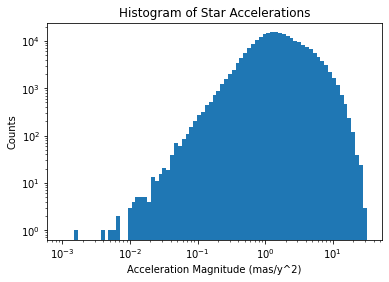

In [115]:
plt.hist(accel_mags, density=False, log= True, bins=bn) #Diaconis binning
plt.ylabel('Counts')
plt.xscale('log')
plt.xlabel('Acceleration Magnitude (mas/y^2)');
plt.title('Histogram of Star Accelerations')
print("Average acceleration of this sample: " + str(np.mean(accel_mags)) + " ")
print("Largest acceleration of this sample: " + str(np.max(accel_mags))+ "")
print("Smallest acceleration of this sample: " + str(np.min(accel_mags))+ " ")
print("Variance: " + str(np.var(accel_mags)))

In [131]:
bn1 = np.linspace(0, 30, 100)

Average acceleration/error of this sample: 0.7287925205971031 
Largest acceleration/error of this sample: 28.324004025749336
Smallest acceleration/error of this sample: 0.0005673801469940974 
Variance: 0.3415825199800996


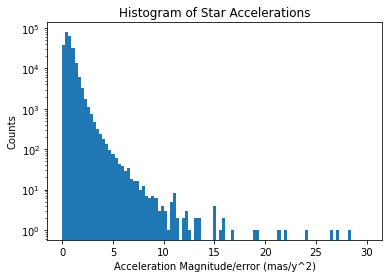

In [132]:
plt.hist(mags_ovr_err, density=False, log= True, bins = bn1) #Diaconis binning
plt.ylabel('Counts')
#plt.xscale('log')
plt.xlabel('Acceleration Magnitude/error (mas/y^2)');
plt.title('Histogram of Star Accelerations')
print("Average acceleration/error of this sample: " + str(np.mean(mags_ovr_err)) + " ")
print("Largest acceleration/error of this sample: " + str(np.max(mags_ovr_err))+ "")
print("Smallest acceleration/error of this sample: " + str(np.min(mags_ovr_err))+ " ")
print("Variance: " + str(np.var(mags_ovr_err)))

In [120]:
accels_ra = accels[:,0]

In [121]:
bn2 = np.linspace(-30, 30, 70)

Average acceleration of this sample: -0.40037224738035937 
Largest acceleration of this sample: 22.807915989380422
Smallest acceleration of this sample: -32.057723837259296 
Variance: 4.718193119284295


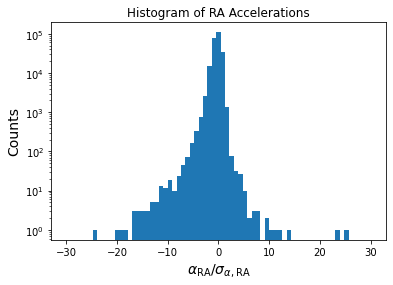

In [129]:
plt.hist(accels_ra/accel_ra_error, density=False, log= True, bins=bn2) #Diaconis binning
plt.ylabel('Counts', fontsize=14)
#plt.xscale('log')
plt.xlabel(r'$\alpha_\mathrm{RA}/\sigma_{\alpha, \mathrm{RA}}$', fontsize=14);
plt.title('Histogram of RA Accelerations')
print("Average acceleration of this sample: " + str(np.mean(accels_ra)) + " ")
print("Largest acceleration of this sample: " + str(np.max(accels_ra))+ "")
print("Smallest acceleration of this sample: " + str(np.min(accels_ra))+ " ")
print("Variance: " + str(np.var(accels_ra)))

In [123]:
accels_dec = accels[:,1]

Average acceleration of this sample: 0.5845755728791507 
Largest acceleration of this sample: 30.46037757888272
Smallest acceleration of this sample: -24.8120630231583 
Variance: 5.2983417293057755


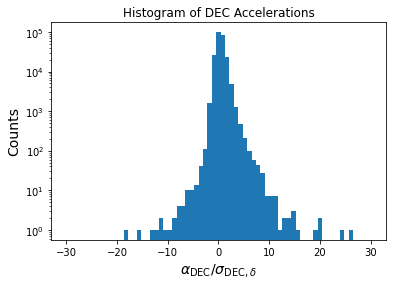

In [130]:
plt.hist(accels_dec/accel_ra_error, density=False, log= True, bins=bn2) #Diaconis binning
plt.ylabel('Counts', fontsize=14)
#plt.xscale('log')
plt.xlabel(r'$\alpha_\mathrm{DEC}/\sigma_{\mathrm{DEC}, \delta}$', fontsize=14);
plt.title(r'Histogram of DEC Accelerations')
print("Average acceleration of this sample: " + str(np.mean(accels_dec)) + " ")
print("Largest acceleration of this sample: " + str(np.max(accels_dec))+ "")
print("Smallest acceleration of this sample: " + str(np.min(accels_dec))+ " ")
print("Variance: " + str(np.var(accels_dec)))

# Checks on the get norm function

In [33]:
def get_norm_new(pairs_list):
    
    z = propagate_back_linear(pairs_list['ra'].to_numpy(), pairs_list['dec'].to_numpy(), pairs_list['pmra'].to_numpy(), pairs_list['pmdec'].to_numpy())
    pairs_list['ra_2'] = z.ra.deg
    pairs_list['dec_2'] = z.dec.deg
    
#    ra_offset = (pairs_list['ra_2']-pairs_list['ra.1'])*np.cos(pairs_list['dec_2']*myU.degree)*myU.degree/myU.mas
#    dec_offset = (pairs_list['dec_2']-pairs_list['dec.1'])*myU.degree/myU.mas
    ra_offset = (pairs_list['ra']-pairs_list['ra.1'])*np.cos(pairs_list['dec']*myU.degree)*myU.degree/myU.mas
    dec_offset = (pairs_list['dec']-pairs_list['dec.1'])*myU.degree/myU.mas
    
    #return np.sqrt(ra_offset**2/pairs_list['ra_error.1']**2), np.sqrt(dec_offset**2/pairs_list['dec_error.1']**2)
    return np.sqrt(ra_offset**2/pairs_list['ra_error']**2), np.sqrt(dec_offset**2/pairs_list['dec_error']**2)

In [34]:
aa = get_norm_new(pair_df)

<ipython-input-33-4bfb656f318b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pairs_list['ra_2'] = z.ra.deg
<ipython-input-33-4bfb656f318b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pairs_list['dec_2'] = z.dec.deg


In [35]:
np.max(aa[0].to_numpy())

1125.1466049243595

In [27]:
bn = np.logspace(-3,5.5,50)

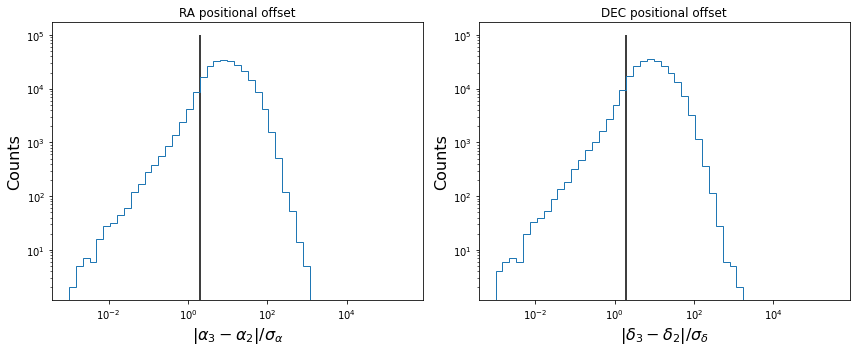

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

ax[0].minorticks_on()
ax[0].hist(aa[0], density=False, log= True, bins=bn, histtype='step', stacked=False, fill=False)
ax[0].set_xscale('log')
ax[0].set_ylabel('Counts', fontsize=16); ax[0].set_xlabel(r'$|\alpha_3 - \alpha_2|/\sigma_\alpha$', fontsize=16)
ax[0].set_title('RA positional offset')
ax[0].vlines(2, 0, 1E5, colors='k', linestyles='solid')

ax[1].minorticks_on()
ax[1].hist(aa[1], density=False, log= True, bins=bn, histtype='step', stacked=False, fill=False)
ax[1].set_xscale('log')
ax[1].set_ylabel('Counts', fontsize=16); ax[1].set_xlabel(r'$|\delta_3 - \delta_2|/\sigma_\delta$', fontsize=16)
ax[1].set_title('DEC positional offset')
ax[1].vlines(2, 0, 1E5, colors='k', linestyles='solid')

fig.tight_layout()

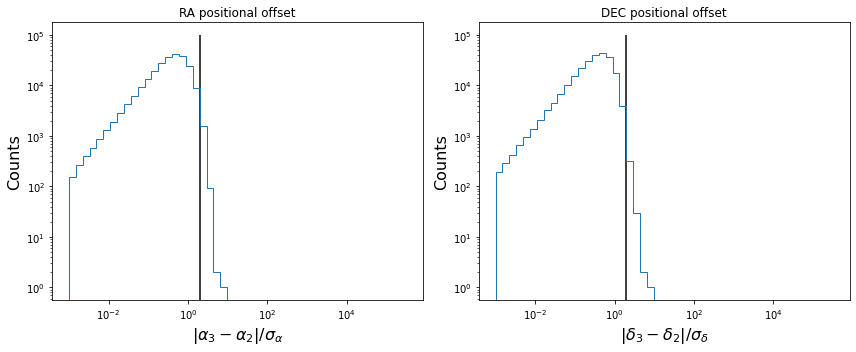

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

ax[0].minorticks_on()
ax[0].hist(aa[0], density=False, log= True, bins=bn, histtype='step', stacked=False, fill=False)
ax[0].set_xscale('log')
ax[0].set_ylabel('Counts', fontsize=16); ax[0].set_xlabel(r'$|\alpha_3 - \alpha_2|/\sigma_\alpha$', fontsize=16)
ax[0].set_title('RA positional offset')
ax[0].vlines(2, 0, 1E5, colors='k', linestyles='solid')

ax[1].minorticks_on()
ax[1].hist(aa[1], density=False, log= True, bins=bn, histtype='step', stacked=False, fill=False)
ax[1].set_xscale('log')
ax[1].set_ylabel('Counts', fontsize=16); ax[1].set_xlabel(r'$|\delta_3 - \delta_2|/\sigma_\delta$', fontsize=16)
ax[1].set_title('DEC positional offset')
ax[1].vlines(2, 0, 1E5, colors='k', linestyles='solid')

fig.tight_layout()

# Checks on back-propagation

In [84]:
def propagate_back_linear(ra_g3, dec_g3, pmra_g3, pmdec_g3):
    """Takes EDR3 position and proper motion, and linearly propagates it by 0.5 year to the DR2 epoch. Output: SkyCoord object in DR2 epoch. Does not take into account parallax."""
    c = SkyCoord(ra = ra_g3 * u.deg, 
                 dec = dec_g3 * u.deg, 
                 distance = 1 * u.kpc, #setting distance to 1 kpc, otherwise it thinks stuff is at 10 Mpc and then returns an exception due to faster than light
                 pm_ra_cosdec = pmra_g3 * u.mas/u.yr,
                 pm_dec = pmdec_g3 * u.mas/u.yr,
                 obstime = Time(2016.0, format='jyear'))
    return c.apply_space_motion(Time(2015.5, format='jyear'))

In [80]:
def propagate_back_linear_2(ra_g3, dec_g3, pmra_g3, pmdec_g3):
    """Takes EDR3 position and proper motion, and linearly propagates it by 0.5 year to the DR2 epoch. Output: SkyCoord object in DR2 epoch. Does not take into account parallax."""
    c = SkyCoord(ra = ra_g3 * u.deg, 
                 dec = dec_g3 * u.deg, 
                 distance = 0.5 * u.kpc, #setting distance to 1 kpc, otherwise it thinks stuff is at 10 Mpc and then returns an exception due to faster than light
                 pm_ra_cosdec = pmra_g3 * u.mas/u.yr,
                 pm_dec = pmdec_g3 * u.mas/u.yr,
                 obstime = Time(2016.0, format='jyear'))
    return c.apply_space_motion(Time(2015.5, format='jyear'))

In [91]:
def my_propagate_back_linear(ra_g3, dec_g3, pmra_g3, pmdec_g3):
    """Takes EDR3 position and proper motion, and linearly propagates it by 0.5 year to the DR2 epoch. Output: SkyCoord object in DR2 epoch. Does not take into account parallax."""
    ra_g3_2 = ra_g3 - pmra_g3*0.5*myU.mas/myU.degree/np.cos(dec_g3*myU.degree); dec_g3_2 = dec_g3 - pmdec_g3*0.5*myU.mas/myU.degree
    
    return ra_g3_2, dec_g3_2

In [92]:
z = propagate_back_linear(pair_df['ra'].to_numpy(), pair_df['dec'].to_numpy(), pair_df['pmra'].to_numpy(), pair_df['pmdec'].to_numpy())

In [82]:
z_2 = propagate_back_linear_2(pair_df['ra'].to_numpy(), pair_df['dec'].to_numpy(), pair_df['pmra'].to_numpy(), pair_df['pmdec'].to_numpy())

In [83]:
np.max(np.abs(z_2.ra.deg-z.ra.deg))/myU.mas, np.max(np.abs(z_2.dec.deg-z.dec.deg))/myU.mas

(0.002849125616992547, 0.003527698230504661)

In [93]:
z_ra, z_dec = my_propagate_back_linear(pair_df['ra'].to_numpy(), pair_df['dec'].to_numpy(), pair_df['pmra'].to_numpy(), pair_df['pmdec'].to_numpy())

In [94]:
np.max(np.abs(z_ra-z.ra.deg))/myU.mas, np.max(np.abs(z_dec-z.dec.deg))/myU.mas

(0.009590883764197134, 0.014346754457170804)

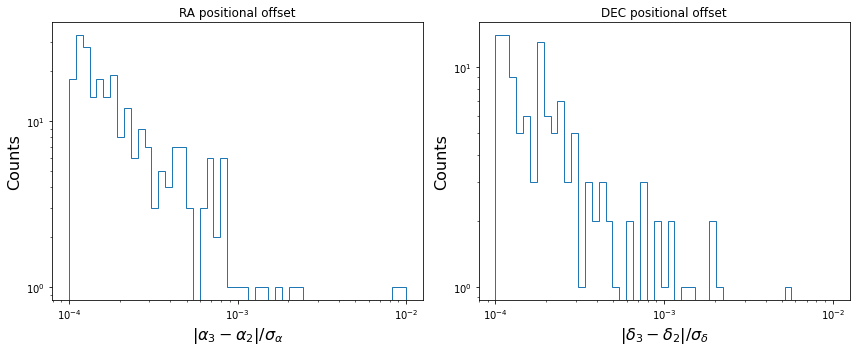

In [96]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
bn = np.logspace(-4, -2, 50)

ax[0].minorticks_on()
ax[0].hist(np.abs(z_ra-z.ra.deg)/myU.mas, density=False, log= True, bins=bn, histtype='step', stacked=False, fill=False)
ax[0].set_xscale('log')
ax[0].set_ylabel('Counts', fontsize=16); ax[0].set_xlabel(r'$|\alpha_3 - \alpha_2|/\sigma_\alpha$', fontsize=16)
ax[0].set_title('RA positional offset')

ax[1].minorticks_on()
ax[1].hist(np.abs(z_dec-z.dec.deg)/myU.mas, density=False, log= True, bins=bn, histtype='step', stacked=False, fill=False)
ax[1].set_xscale('log')
ax[1].set_ylabel('Counts', fontsize=16); ax[1].set_xlabel(r'$|\delta_3 - \delta_2|/\sigma_\delta$', fontsize=16)
ax[1].set_title('DEC positional offset')

fig.tight_layout()

# Looking at an Outlier

In [225]:
outlier_mag = pair_df.iloc[np.argmax(accel_mags)]
outlier_mag

solution_id                         1636042515805110273
designation               Gaia EDR3 5305318052732229632
source_id                           5305318052732229632
random_index                                 1299445472
ref_epoch                                          2016
                                      ...              
lum_percentile_lower.1                              NaN
lum_percentile_upper.1                              NaN
ra_2                                             143.38
dec_2                                          -59.7749
norm                                            1.12901
Name: 401833, Length: 196, dtype: object

In [290]:
mags_ovr_err[np.argmax(accel_mags)]

1922.318573843862

In [241]:
print('RA :' + str((outlier_mag['ra_2'],outlier_mag['ra.1'])))
print('DEC :' + str((outlier_mag['dec_2'],outlier_mag['dec.1'])))
print('PMRA :' + str((outlier_mag['pmra'],outlier_mag['pmra.1'])))
print('PMDEC :' + str((outlier_mag['pmdec'],outlier_mag['pmdec.1'])))
print('PAR :' + str((outlier_mag['parallax'],outlier_mag['parallax.1'])))
print('PHOT_BP :' + str((outlier_mag['phot_bp_mean_flux'],outlier_mag['phot_bp_mean_flux.1'])))
print('PHOT_RP :' + str((outlier_mag['phot_rp_mean_flux'],outlier_mag['phot_rp_mean_flux.1'])))

RA :(143.3802495410761, 143.37998562893424)
DEC :(-59.774931236870174, -59.77575331251915)
PMRA :(-4.24265385608839, -3.255564174985812)
PMDEC :(2.943723728975175, 2.5294546763291343)
PAR :(-0.3294924148927294, -0.0877150898562728)
PHOT_BP :(116.63845984519594, nan)
PHOT_RP :(224.08149135729823, nan)


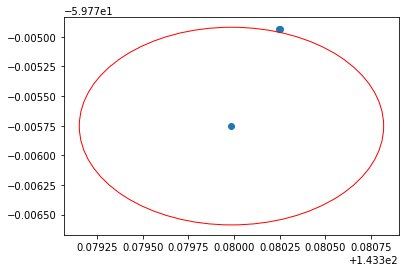

In [263]:
ra = [outlier_mag['ra'], outlier_mag['ra_2'],outlier_mag['ra.1']]
dec = [outlier_mag['dec'], outlier_mag['dec_2'],outlier_mag['dec.1']]
circle = plt.Circle((outlier_mag['ra.1'], outlier_mag['dec.1']), 3*myU.arcsec/myU.degree, edgecolor='red',fill =False)
fig, ax = plt.subplots() # note we must use plt.subplots, not plt.subplot
ax.add_patch(circle)
plt.scatter(ra, dec)
plt.show()

In [229]:
outlier_moe = pair_df.iloc[np.argmax(mags_ovr_err)] #outlier with greatest magnitude over error
outlier_moe

solution_id                         1636042515805110273
designation               Gaia EDR3 5305007990432892416
source_id                           5305007990432892416
random_index                                  238294138
ref_epoch                                          2016
                                      ...              
lum_percentile_lower.1                              NaN
lum_percentile_upper.1                              NaN
ra_2                                            134.741
dec_2                                          -55.8755
norm                                           0.801091
Name: 38064, Length: 196, dtype: object

In [242]:
print('RA :' + str((outlier_moe['ra_2'],outlier_moe['ra.1'])))
print('DEC :' + str((outlier_moe['dec_2'],outlier_moe['dec.1'])))
print('PMRA :' + str((outlier_moe['pmra'],outlier_moe['pmra.1'])))
print('PMDEC :' + str((outlier_moe['pmdec'],outlier_moe['pmdec.1'])))
print('PAR :' + str((outlier_moe['parallax'],outlier_moe['parallax.1'])))
print('PHOT_BP :' + str((outlier_moe['phot_bp_mean_flux'],outlier_moe['phot_bp_mean_flux.1'])))
print('PHOT_RP :' + str((outlier_moe['phot_rp_mean_flux'],outlier_moe['phot_rp_mean_flux.1'])))

RA :(134.74095741253237, 134.7405663375493)
DEC :(-55.875478034380556, -55.8751441060888)
PMRA :(-5.754725688960259, -5.729756034215679)
PMDEC :(5.999794957262307, 6.032974202188338)
PAR :(0.8696854483576261, 0.8229335605134653)
PHOT_BP :(28512.629088805406, nan)
PHOT_RP :(40804.77554651215, nan)


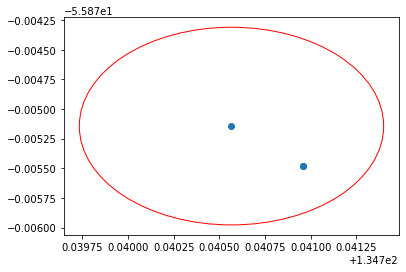

In [262]:
ra = [outlier_moe['ra'], outlier_moe['ra_2'],outlier_moe['ra.1']]
dec = [outlier_moe['dec'], outlier_moe['dec_2'],outlier_moe['dec.1']]
circle = plt.Circle((outlier_moe['ra.1'], outlier_moe['dec.1']), 3*myU.arcsec/myU.degree, edgecolor='red',fill =False)
fig, ax = plt.subplots() # note we must use plt.subplots, not plt.subplot
ax.add_patch(circle)
plt.scatter(ra, dec)
plt.show()

# Old Stuff

In [43]:
def generate_accel_cat(dr3, dr2):
    
    pairs_list = generate_pairs_list(dr3,dr2)
    pair_df = match_pairs(pairs_list)
    pair_df = pair_df[~pair_df['pmra'].isna() & ~pair_df['pmra.1'].isna()]
    
    #making lists of the function inputs.
    ra2_list = np.array(pair_df['ra.1'])
    ra3_list = np.array(pair_df['ra'])

    dec2_list = np.array(pair_df['dec.1'])
    dec3_list = np.array(pair_df['dec'])

    ra2_error = np.array(pair_df['ra_error.1'])
    ra3_error = np.array(pair_df['ra_error'])

    dec2_error = np.array(pair_df['dec_error.1'])
    dec3_error = np.array(pair_df['dec_error'])
    
    pmra3 = np.asarray(pair_df['pmra'])
    pmdec3 = np.asarray(pair_df['pmdec'])

    pmra2 = np.asarray(pair_df['pmra.1'])
    pmdec2 = np.asarray(pair_df['pmdec.1'])
    
    #compute lists of accelerations
    accel_ra = hacky_accel_ra(ra2_list, ra3_list, pmra2, pmra3)
    accel_dec = hacky_accel_dec(dec2_list, dec3_list, pmdec2, pmdec3)
    accel_mag_list = accel_mag(accel_ra, accel_dec)
    accel_mag_error_list = hacky_error(ra2_error, dec2_error, ra3_error, dec3_error)
    mag_ovr_error = mag_over_error(accel_mag_list, accel_mag_error_list)
    
    pair_df['accel_ra'] = accel_ra
    pair_df['accel_dec'] = accel_dec
    pair_df['accel_mag'] = accel_mag_list
    pair_df['mag_over_error'] = mag_ovr_error
    
    return pair_df

In [50]:
accel_cat1 = generate_accel_cat(dr3, dr2)

/home/andreas/anaconda3/envs/lens_project/lib/python3.9/site-packages/erfa/core.py:4721: RuntimeWarning: invalid value encountered in pmsafe
  ra2, dec2, pmr2, pmd2, px2, rv2, c_retval = ufunc.pmsafe(
/home/andreas/anaconda3/envs/lens_project/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "pmsafe" yielded 55949 of "solution didn't converge (Note 8)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),
/tmp/ipykernel_111/2254177642.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_cut.sort_values(['source_id', 'norm'], ascending = [True, True],inplace=True)
/tmp/ipykernel_111/2254177642.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

In [84]:
accel_cat1

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,...,lum_val.1,lum_percentile_lower.1,lum_percentile_upper.1,ra_2,dec_2,norm,accel_ra,accel_dec,accel_mag,mag_over_error
3,1636042515805110273,Gaia EDR3 5304967682164882432,5304967682164882432,1335312831,2016.0,134.260537,0.178428,-56.437124,0.195209,-0.175690,...,NaN,NaN,NaN,134.260538,-56.437124,2.021810,13.488703,-11.501294,17.726389,16.515249
5,1636042515805110273,Gaia EDR3 5304967682164882944,5304967682164882944,1444571071,2016.0,134.242473,0.247878,-56.435970,0.257689,0.337269,...,NaN,NaN,NaN,134.242474,-56.435970,1.756193,20.962990,-9.522682,23.024518,15.420132
6,1636042515805110273,Gaia EDR3 5304967682164884608,5304967682164884608,1746916597,2016.0,134.261234,0.121844,-56.434013,0.139065,0.342005,...,NaN,NaN,NaN,134.261234,-56.434014,2.311549,11.162223,-14.011733,17.914349,23.891971
7,1636042515805110273,Gaia EDR3 5304967682164884736,5304967682164884736,1517284186,2016.0,134.258238,0.107684,-56.433976,0.121828,0.154727,...,NaN,NaN,NaN,134.258239,-56.433977,2.394400,10.263577,-6.805512,12.314869,18.876732
8,1636042515805110273,Gaia EDR3 5304967682164884864,5304967682164884864,600221900,2016.0,134.245005,0.070754,-56.434983,0.074656,0.170320,...,NaN,NaN,NaN,134.245006,-56.434983,2.240632,12.078442,-16.675219,20.590087,47.900877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
666015,1636042515805110273,Gaia EDR3 5305504213790885504,5305504213790885504,1362302113,2016.0,144.747969,0.572486,-58.365977,0.623483,-0.647407,...,NaN,NaN,NaN,144.747971,-58.365978,0.690064,36.479946,-9.648157,37.734247,11.148155
666017,1636042515805110273,Gaia EDR3 5305504213790924672,5305504213790924672,604889548,2016.0,144.755072,0.538898,-58.363640,0.532039,0.913234,...,NaN,NaN,NaN,144.755073,-58.363640,3.479993,15.271458,-14.613921,21.137269,7.298480
666020,1636042515805110273,Gaia EDR3 5305504213791410432,5305504213791410432,1572829936,2016.0,144.730174,1.126810,-58.362296,1.691526,-0.473630,...,NaN,NaN,NaN,144.730174,-58.362296,1.109263,-5.122595,-7.312608,8.928338,1.174746
666026,1636042515805110273,Gaia EDR3 5305504213791424640,5305504213791424640,566170440,2016.0,144.753855,0.783709,-58.361383,0.819308,1.215089,...,NaN,NaN,NaN,144.753857,-58.361383,0.986318,29.465180,-13.742266,32.512254,6.916535


In [61]:
outlier = accel_cat1.iloc[np.argmax(accel_cat1['mag_over_error'])]

In [79]:
outl3 = [outlier['ra'], outlier['dec'], outlier['pmra'], outlier['pmdec'], outlier['parallax'], outlier['phot_bp_mean_flux'], outlier['phot_rp_mean_flux'] ]

In [80]:
outl3

[134.74095598779627,
 -55.8754772010757,
 -5.754725688960259,
 5.999794957262308,
 0.8696854483576261,
 28512.629088805403,
 40804.77554651215]

In [81]:
outl2 = [outlier['ra.1'], outlier['dec.1'], outlier['pmra.1'], outlier['pmdec.1'], outlier['parallax.1'], outlier['phot_bp_mean_flux.1'], outlier['phot_rp_mean_flux.1'] ]

In [82]:
outl2

[134.7405663375493,
 -55.8751441060888,
 -5.72975603421568,
 6.032974202188338,
 0.8229335605134653,
 nan,
 nan]

In [83]:
outlier['norm']

0.8011048698785528

# Plots

In [68]:
accel_mag_list = np.asarray(accel_cat['accel_mag'])
accel_ra_list =  np.asarray(accel_cat['accel_ra'])
accel_dec_list = np.asarray(accel_cat['accel_dec'])
mag_ovr_error = np.asarray(accel_cat['mag_over_error'])
bn = np.logspace(-1,4.5,200)

Acceleration Magnitude:

In [171]:
plt.hist(mag_ovr_error, density=False, log= True, bins=bn) #Diaconis binning
plt.ylabel('Counts')
plt.xlabel('Acceleration Magnitude (mas/y^2)');
plt.title('Histogram of Star Accelerations (RUWE < 1.4)')
print("Average acceleration of this sample: " + str(np.mean(accel_mag_list)) + " ")
print("Largest acceleration of this sample: " + str(np.max(accel_mag_list))+ "")
print("Smallest acceleration of this sample: " + str(np.min(accel_mag_list))+ " ")
print("Variance: " + str(np.var(accel_mag_list)))

NameError: name 'mag_ovr_error' is not defined

In [70]:
accel_mag_list = np.asarray(accel_cat1['accel_mag'])
accel_ra_list =  np.asarray(accel_cat1['accel_ra'])
accel_dec_list = np.asarray(accel_cat1['accel_dec'])
mag_ovr_error = np.asarray(accel_cat1['mag_over_error'])
bn = np.logspace(-1,4.5,200)

Average acceleration of this sample: 59.71054906487432 
Largest acceleration of this sample: 14871.699116892905
Smallest acceleration of this sample: 0.043103822095201236 
Variance: 330986.6540340782


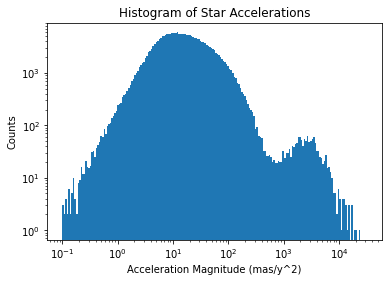

In [71]:
plt.hist(mag_ovr_error, density=False, log= True, bins=bn) #Diaconis binning
plt.ylabel('Counts')
plt.xscale('log')
plt.xlabel('Acceleration Magnitude (mas/y^2)');
plt.title('Histogram of Star Accelerations')
print("Average acceleration of this sample: " + str(np.mean(accel_mag_list)) + " ")
print("Largest acceleration of this sample: " + str(np.max(accel_mag_list))+ "")
print("Smallest acceleration of this sample: " + str(np.min(accel_mag_list))+ " ")
print("Variance: " + str(np.var(accel_mag_list)))

Acceleration in Right Ascension

Average acceleration of this sample: 16.13538535839183 
Largest acceleration of this sample: 14870.837519973327
Smallest acceleration of this sample: -14797.483478447055 
Variance: 261672.48118405524


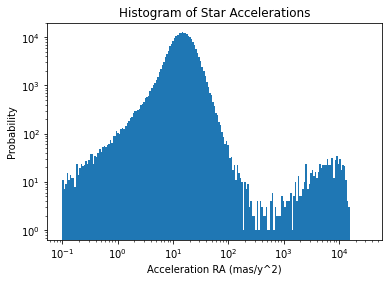

In [47]:
plt.hist(accel_ra_list, density=False, log= True, bins=bn) #Diaconis binning
plt.ylabel('Probability')
plt.xscale('log')
plt.xlabel('Acceleration RA (mas/y^2)');
plt.title('Histogram of Star Accelerations')
print("Average acceleration of this sample: " + str(np.mean(accel_ra_list)) + " ")
print("Largest acceleration of this sample: " + str(max(accel_ra_list))+ "")
print("Smallest acceleration of this sample: " + str(min(accel_ra_list))+ " ")
print("Variance: " + str(np.var(accel_ra_list)))

Average acceleration of this sample: -10.427068468783737 
Largest acceleration of this sample: 7427.150625031959
Smallest acceleration of this sample: -7505.532940547233 
Variance: 72510.4481021351


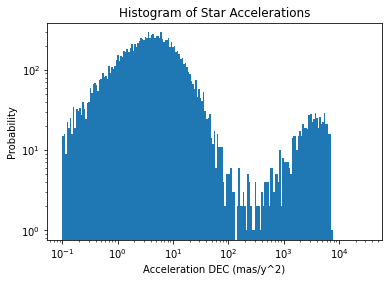

In [48]:
plt.hist(accel_dec_list, density=False, log= True, bins=bn) #Diaconis binning
plt.ylabel('Probability')
plt.xscale('log')
plt.xlabel('Acceleration DEC (mas/y^2)');
plt.title('Histogram of Star Accelerations')
print("Average acceleration of this sample: " + str(np.mean(accel_dec_list)) + " ")
print("Largest acceleration of this sample: " + str(max(accel_dec_list))+ "")
print("Smallest acceleration of this sample: " + str(min(accel_dec_list))+ " ")
print("Variance: " + str(np.var(accel_dec_list)))